# Sentiment Analysis with LSTM in PyTorch

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from string import punctuation
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# load dataset
df = pd.read_csv('sentiment labelled sentences/amazon_cells_labelled.txt', 
                 sep='\t', 
                 names=['reviews', 'sentiment'])
df.head()

,reviews,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [3]:
# separate data into two variables
X = df['reviews']
y = np.array(df['sentiment'])

In [4]:
# remove punctuation from reviews and tokenize
X = [re.sub(f'[{punctuation}]', '', review) for review in X]

tokenizer = nltk.RegexpTokenizer(r'\w+')
X_tokens = [tokenizer.tokenize(review) for review in X]

In [5]:
# create variable with vocabulary of the entire set of reviews
vocab = set(list(np.concatenate(X_tokens).flat))
print('length of vocabulary:', len(vocab))

length of vocabulary: 2220


In [6]:
# mapping word to integer dictionary 
word2int = {word:integer for integer, word in enumerate(vocab)}
word2int

{'iPhone': 0,
 'rating': 1,
 'our': 2,
 'strange': 3,
 'break': 4,
 'loops': 5,
 'loads': 6,
 'customer': 7,
 'gels': 8,
 'replaced': 9,
 'SUPERB': 10,
 'unbearable': 11,
 'ActiveSync': 12,
 'doing': 13,
 'spring': 14,
 'toilet': 15,
 'Really': 16,
 'purchase': 17,
 'enough': 18,
 'majority': 19,
 'Wirefly': 20,
 'receptionsound': 21,
 'biggest': 22,
 'Treo': 23,
 'havent': 24,
 'what': 25,
 'effort': 26,
 'phones2': 27,
 'winner': 28,
 'literally': 29,
 'sturdy': 30,
 'signals': 31,
 'v115g': 32,
 'cancelling': 33,
 'plugs': 34,
 'PIECE': 35,
 'rare': 36,
 'source': 37,
 'HATED': 38,
 'breaks': 39,
 'he': 40,
 'fine': 41,
 'drawback': 42,
 'expensive': 43,
 'sources': 44,
 'does': 45,
 'feature': 46,
 'dialing': 47,
 'luck': 48,
 'Last': 49,
 'video': 50,
 'takes': 51,
 'players': 52,
 'additional': 53,
 'Love': 54,
 'echo': 55,
 'organizational': 56,
 'flash': 57,
 'others': 58,
 'exercise': 59,
 'old': 60,
 'enjoy': 61,
 'guess': 62,
 'Choice': 63,
 'locked': 64,
 'addition': 65,
 '

In [7]:
# encode the reviews data by replacing each word with its paired integer
X = [[word2int[w] for w in review.split()] for review in X]

In [8]:
# padding 
# modified from: https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948 
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(X), seq_length), dtype = int)
    
    for i, review in enumerate(X):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

X = pad_features(X, 21)

In [9]:
train_ratio = 0.8
valid_ratio = (1 - train_ratio)/2

total = len(X)
train_cutoff = int(total * train_ratio)
valid_cutoff = int(total * (1 - valid_ratio))

train_x, train_y = torch.Tensor(X[:train_cutoff]).long(), torch.Tensor(y[:train_cutoff]).long()
valid_x, valid_y = torch.Tensor(X[train_cutoff : valid_cutoff]).long(), torch.Tensor(y[train_cutoff : valid_cutoff]).long()
test_x, test_y = torch.Tensor(X[valid_cutoff:]).long(), torch.Tensor(y[valid_cutoff:])

train_data = TensorDataset(train_x, train_y)
valid_data = TensorDataset(valid_x, valid_y)
test_data = TensorDataset(test_x, test_y)

batch_size = 1

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [10]:
# create class with the NN architecture
class ARnn(nn.Module):
    def __init__(self, n_vocab, embed_size, hidden_size, num_classes, bs=1, num_layers=3, drop_p = 0.8):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.bs = bs
        self.num_layers = num_layers
        self.drop_p = drop_p
        
        self.e = nn.Embedding(n_vocab,embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(hidden_size,num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_words):
        e_out = self.e(input_words)
        lstm_out, h = self.lstm(e_out) 
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)
        fc_out = self.fc(lstm_out)                  
        sigmoid_out = self.sigmoid(fc_out)              
        sigmoid_out = sigmoid_out.view(batch_size, -1)  
        
        sigmoid_last = sigmoid_out[:, -1]
        
        return sigmoid_last, h
    
    def init_hidden (self, batch_size):
        
        device = "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.num_layers, self.bs, self.hidden_size).zero_().to(device),
             weights.new(self.num_layers, self.bs, self.hidden_size).zero_().to(device))
        
        return h

In [11]:
# define params
n_vocab = len(vocab)
embedding_dimensions = 64
neurons = 128
epochs = 10
step = 0
clip = 5

In [12]:
# build the LSTM model
model = ARnn(n_vocab, embedding_dimensions, neurons, 2)

In [13]:
# loss function, optimization algorithm
criterion = torch.nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
print(model)

ARnn(
  (e): Embedding(2220, 64)
  (lstm): LSTM(64, 128, num_layers=3, batch_first=True, dropout=0.8)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [15]:
model.train()
loss_lst = []
time_lst = []
correct_lst = []
for epoch in range(epochs):
    h = model.init_hidden(batch_size)
    num_correct = 0
    
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        step += 1
        model.zero_grad()
        output, h = model(inputs)
        labels = labels.unsqueeze(-1)
        loss = criterion(output.unsqueeze(-1), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        # accuracy
        preds = torch.round(output.squeeze())
        correct_tensor = preds.eq(labels.float().view_as(preds))
        correct = np.squeeze(correct_tensor.numpy())
        num_correct += np.sum(correct)
        acc = (num_correct/len(train_loader.dataset))
        
        if (step % 800) == 0:            
            model.eval()

            loss_lst.append(loss.item())
            time_lst.append(step) 
            correct_lst.append(acc)
            
            print(f"Epoch: {(epoch+1)}/{epochs}",
                  f"Step: {step}",
                  f"Training Loss: {loss.item()}",
                  f"Training Accuracy: {acc}")
            model.train()

Epoch: 1/10 Step: 800 Training Loss: 0.5633434653282166 Training Accuracy: 0.4925
Epoch: 2/10 Step: 1600 Training Loss: 0.2084277719259262 Training Accuracy: 0.63375
Epoch: 3/10 Step: 2400 Training Loss: 0.21099531650543213 Training Accuracy: 0.7825
Epoch: 4/10 Step: 3200 Training Loss: 0.0007370445528067648 Training Accuracy: 0.8725
Epoch: 5/10 Step: 4000 Training Loss: 0.0019137682393193245 Training Accuracy: 0.92625
Epoch: 6/10 Step: 4800 Training Loss: 0.0013903504004701972 Training Accuracy: 0.96
Epoch: 7/10 Step: 5600 Training Loss: 0.0007289323839358985 Training Accuracy: 0.97125
Epoch: 8/10 Step: 6400 Training Loss: 1.0967314665322192e-05 Training Accuracy: 0.98
Epoch: 9/10 Step: 7200 Training Loss: 0.00013316563854459673 Training Accuracy: 0.97125
Epoch: 10/10 Step: 8000 Training Loss: 0.005421766079962254 Training Accuracy: 0.98


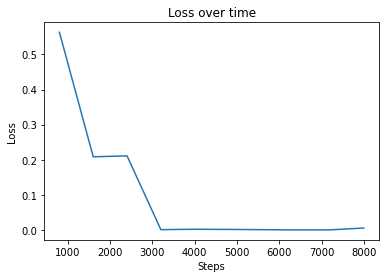

In [16]:
# plot loss
plt.plot(time_lst, loss_lst)
plt.title('Loss over time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

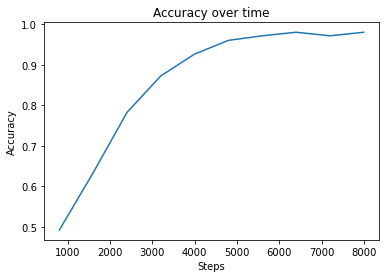

In [17]:
# plot accuracy
plt.plot(time_lst, correct_lst)
plt.title('Accuracy over time')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.show()

In [18]:
model.eval()
test_losses = []
num_correct = 0

for inputs, labels in test_loader:

    test_output, test_h = model(inputs)
    loss = criterion(test_output, labels)
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds))
    correct = np.squeeze(correct_tensor.numpy())
    num_correct += np.sum(correct)
    
print(f"Test Loss: {np.mean(test_losses)}")
print(f"Test Accuracy: {num_correct/len(test_loader.dataset)}") 

Test Loss: 2.077186478320582
Test Accuracy: 0.65
